In [1]:

# use those exact versions in the installation
!pip install torch-geometric pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
# install other stuff
!pip install  bravado pandas numpy networkx
!pip install igraph matplotlib cairocffi
# check the installation

from typing import List, Dict, Tuple
import requests
import pandas as pd
import networkx as nx
import torch
import torch_geometric
from torch_geometric.data import Data
from bravado.client import SwaggerClient

import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(f"PyG version: {torch_geometric.__version__}")



Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
PyG version: 2.6.1


In [49]:
# -------------------------------
# 1. Obtener Red PPI con STRINGdb
# -------------------------------

def get_stringdb_interactions(genes: List[str], species: int = 9606, score_threshold: int = 900) -> pd.DataFrame:
    """
    Obtiene las interacciones proteína-proteína (PPI) para una lista de genes desde STRINGdb.

    Args:
        genes (List[str]): Lista de genes/proteínas.
        species (int): ID de especie (9606 para humanos).
        score_threshold (int): Umbral de score de confianza (0-1000).

    Returns:
        pd.DataFrame: DataFrame con pares de proteínas y su score de interacción.
    """
    url = "https://string-db.org/api/json/network"
    params = {
        "identifiers": "%0d".join(genes),
        "species": species,
        "required_score": score_threshold,
        "limit": 1000
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    interactions = response.json()

    # Procesar resultados
    data = [{
        "protein1": entry["preferredName_A"],
        "protein2": entry["preferredName_B"],
        "score": entry["score"]
    } for entry in interactions]
    df = pd.DataFrame(data)

    # Filtrar interacciones para que solo incluyan genes en la lista original
    filtered_df = df[(df["protein1"].isin(genes)) & (df["protein2"].isin(genes))]
    return filtered_df

# -------------------------------
# 2. Obtener Vecinos de STRINGdb
# -------------------------------

def get_stringdb_neighbors(genes: List[str], limit: int = 30, species: int = 9606, score_threshold: int = 900) -> pd.DataFrame:
    """
    Expande la red obteniendo los socios de interacción de STRINGdb para los genes especificados.

    Args:
        genes (List[str]): Lista de genes/proteínas iniciales.
        limit (int): Máximo número de socios de interacción por proteína.
        species (int): ID de especie (9606 para humanos).
        score_threshold (int): Umbral de score de confianza (0-1000).

    Returns:
        pd.DataFrame: DataFrame con las interacciones proteína-proteína y scores.
    """
    url = "https://string-db.org/api/json/interaction_partners"
    expanded_interactions = []

    params = {
        "identifiers": genes,
        "species": species,
        "limit": limit,
        "required_score": score_threshold,
        "caller_identity": "my_custom_pipeline"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    interactions = response.json()

    for entry in interactions:
        expanded_interactions.append({
            "protein1": entry["preferredName_A"],
            "protein2": entry["preferredName_B"],
            "score": entry["score"]
        })

    return pd.DataFrame(expanded_interactions)

# -------------------------------
# 3. Extraer Datos de Expresión de TCGA
# -------------------------------

def get_tcga_expression_data(genes: List[str], study_id: str = "brca_tcga") -> pd.DataFrame:
    """
    Obtiene datos de expresión génica desde cBioPortal para los genes especificados.

    Args:
        genes (List[str]): Lista de genes de interés.
        study_id (str): ID del estudio de TCGA.

    Returns:
        pd.DataFrame: DataFrame con la expresión génica de cada gen por muestra.
    """
    # Inicializar cliente cBioPortal
    cbioportal = SwaggerClient.from_url(
        'https://www.cbioportal.org/api/v2/api-docs',
        config={"validate_requests": False, "validate_responses": False, "validate_swagger_spec": False}
    )

    # Obtener IDs de los genes
    def get_gene_ids(gene_symbols: List[str]) -> Dict[str, int]:
        response = cbioportal.Genes.fetchGenesUsingPOST(geneIdType="HUGO_GENE_SYMBOL", geneIds=gene_symbols).result()
        return {gene.hugoGeneSymbol: gene.entrezGeneId for gene in response}

    gene_ids = get_gene_ids(genes)
    profile_id = "brca_tcga_rna_seq_v2_mrna_median_Zscores"

    # Extraer datos
    filter_data = {
        'molecularProfileIds': [profile_id],
        'entrezGeneIds': list(gene_ids.values())
    }
    expression_data = cbioportal.Molecular_Data.fetchMolecularDataInMultipleMolecularProfilesUsingPOST(
        molecularDataMultipleStudyFilter=filter_data
    ).result()

    # Formatear resultados
    data = [{
        "sample": d.sampleId,
        "gene": str(d.entrezGeneId),
        "value": float(d.value)
    } for d in expression_data if d.value not in [None, "NA"]]
    df = pd.DataFrame(data)
    df["gene"] = df["gene"].map({str(v): k for k, v in gene_ids.items()})
    return df.pivot(index="sample", columns="gene", values="value")

# -------------------------------
# 4. Formato para PyTorch Geometric
# -------------------------------

def create_pyg_data(ppi_df: pd.DataFrame, expression_df: pd.DataFrame) -> Data:
    """
    Crea un objeto Data de PyTorch Geometric a partir de la red PPI y datos de expresión.

    Args:
        ppi_df (pd.DataFrame): DataFrame con interacciones proteicas.
        expression_df (pd.DataFrame): Datos de expresión génica.

    Returns:
        Data: Objeto Data de PyTorch Geometric.
    """
    # Crear lista de nodos y mapping
    nodes = list(expression_df.columns)
    node_map = {gene: i for i, gene in enumerate(nodes)}

    # Crear edge_index
    edges = ppi_df[(ppi_df["protein1"].isin(nodes)) & (ppi_df["protein2"].isin(nodes))]
    edge_index = torch.tensor([
        [node_map[edge["protein1"]], node_map[edge["protein2"]]]
        for _, edge in edges.iterrows()
    ]).t().contiguous()

    # Crear matrix de features
    x = torch.tensor(expression_df.T.values, dtype=torch.float)

    return Data(x=x, edge_index=edge_index)

def filter_ppi_for_expression(ppi_df: pd.DataFrame, expression_genes: List[str]) -> pd.DataFrame:
    """
    Filtra las interacciones PPI para que solo incluyan genes presentes en los datos de expresión.

    Args:
        ppi_df (pd.DataFrame): DataFrame de interacciones PPI.
        expression_genes (List[str]): Lista de genes presentes en la matriz de expresión.

    Returns:
        pd.DataFrame: DataFrame filtrado con interacciones válidas.
    """
    filtered_df = ppi_df[(ppi_df["protein1"].isin(expression_genes)) & (ppi_df["protein2"].isin(expression_genes))]
    return filtered_df

# -------------------------------
# 5. Pipeline General
# -------------------------------

"""
Pipeline general para obtener la red PPI, expandirla, extraer datos de expresión y crear el objeto PyG Data.
"""
genes = ["TP53", "PIK3CA", "RB1", "BRCA1", "PTEN", "ATM", "EGFR", "BRAF", "BRCA2", "AKT1",
          "PIK3R1", "KDR", "NF1", "ERBB4", "JAK2", "NOTCH1", "TRRAP", "MET", "ALK", "CDKN2A"]
ppi_df = get_stringdb_interactions(genes)
expanded_ppi_df = get_stringdb_neighbors(genes)
combined_ppi_df = pd.concat([ppi_df, expanded_ppi_df]).drop_duplicates()

combined_genes = list(set(combined_ppi_df["protein1"]).union(set(combined_ppi_df["protein2"])))
expression_df = get_tcga_expression_data(combined_genes)

# Filtrar interacciones
expression_genes = expression_df.columns.tolist()
filtered_ppi_df = filter_ppi_for_expression(ppi_df, expression_genes) # Nos quitamos genes que hayamos traído que no se tengan los valores de expresión

# Paso 4: Crear objeto PyG Data
pyg_data = create_pyg_data(expanded_ppi_df, expression_df)
print("PyTorch Geometric Data:", pyg_data)


PyTorch Geometric Data: Data(x=[44, 1100], edge_index=[2, 29])


In [48]:
combined_ppi_df.to_csv("combined_ppi.csv", index=False)
expression_df.to_csv("expression_data.csv", index=False)

In [55]:
expression_df

gene,AKT1,ALK,ATM,BCL2,BCL2L1,BRAF,BRCA1,BRCA2,CDKN1A,CDKN2A,...,RCHY1,RPA1,SFN,SIRT1,TP53,TP53BP1,TP53BP2,TRRAP,UBE3A,USP7
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,-0.1227,-0.4017,-0.5045,0.1285,0.9122,-0.3436,1.8364,-0.0566,-0.3843,-0.1220,...,0.7273,-0.8927,0.0459,1.7702,-0.6450,1.4264,-0.2428,1.2664,0.3129,2.2385
TCGA-3C-AALI-01,2.2336,-0.1694,-0.4940,-1.1783,5.3077,0.1498,-0.0175,-0.2291,-0.5079,-0.2110,...,-1.6650,-1.5010,0.2865,-1.8526,-1.9142,-1.0284,0.1487,0.2522,-1.5035,0.0705
TCGA-3C-AALJ-01,1.0921,-0.4292,-0.8699,0.2704,-0.0483,-1.0661,-0.8135,-0.2463,1.1245,-0.0913,...,-1.9732,-2.3449,-0.0730,0.7513,-0.7709,-1.0180,-0.4317,-0.4814,-1.2042,-0.5331
TCGA-3C-AALK-01,0.9570,-0.3633,-0.5577,0.0370,0.8346,-0.8946,-1.0329,-0.5860,0.5884,0.1180,...,-0.8463,-1.8438,0.0818,-1.0790,-0.6022,-0.5075,0.7871,-0.3790,-1.1221,-0.9271
TCGA-4H-AAAK-01,-0.3580,0.2145,-1.2369,-0.3433,1.0375,-1.1191,-0.0769,-0.4014,-0.4118,0.0783,...,-0.1122,-1.6124,-0.0798,-0.9668,-0.5160,-1.1874,-0.4768,-0.1624,-0.2289,-1.0785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,1.3967,-0.2995,-1.0715,-1.2442,-0.8215,-0.7527,-1.5010,-1.2522,1.9496,0.2052,...,-1.4148,-1.9632,0.2558,-1.7751,0.0287,-1.9935,0.3256,-1.2542,-1.4651,-0.1283
TCGA-XX-A899-01,-1.0439,-0.1784,0.7949,-0.6210,0.6345,-0.6040,-0.4545,-0.3484,0.8406,-0.1510,...,0.1603,-0.4998,-0.2148,0.1349,-0.3256,-0.4362,0.1834,0.2232,-0.9631,-1.0007
TCGA-XX-A89A-01,0.3865,-0.4292,-0.2055,-0.8140,0.3070,-0.2386,-0.8197,-0.5969,-0.0915,-0.0135,...,-0.1546,-1.7872,-0.2325,-0.3759,-0.5568,-0.6316,-0.3781,-0.1851,-0.7438,-0.9813


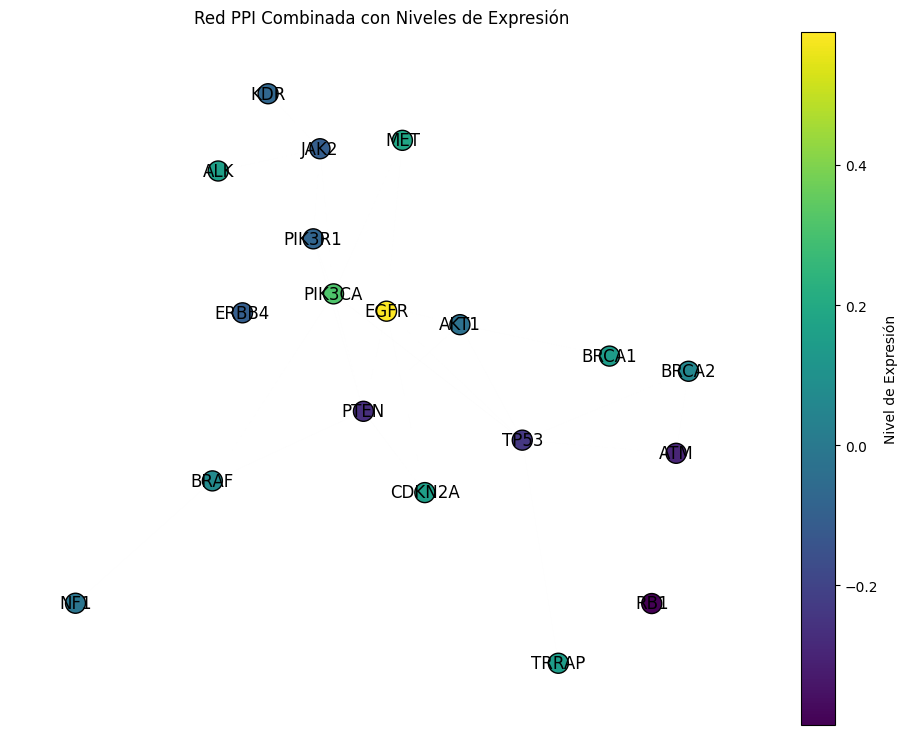

In [52]:
def visualize_network(ppi_df: pd.DataFrame, original_genes: List[str], expression_df: pd.DataFrame) -> None:
    """
    Visualiza la red combinada de interacción PPI, destacando nodos originales y vecinos,
    coloreando los nodos según el nivel de expresión.

    Args:
        ppi_df (pd.DataFrame): DataFrame combinado con las interacciones proteína-proteína.
        original_genes (List[str]): Lista de genes originales proporcionados.
        expression_df (pd.DataFrame): Datos de expresión génica para colorear los nodos.
    """
    # Crear grafo
    G = ig.Graph.TupleList(ppi_df.itertuples(index=False), directed=False, edge_attrs=['score'])

    # Asignar colores a nodos originales y añadidos
    vertex_colors = ["blue" if v["name"] in original_genes else "red" for v in G.vs]

    # Obtener niveles de expresión
    expression_mean = expression_df.mean(axis=0).to_dict()
    expression_colors = [expression_mean.get(v["name"], 0) for v in G.vs]
    norm = plt.Normalize(min(expression_colors), max(expression_colors))
    cmap = cm.viridis
    color_list = [cmap(norm(c)) for c in expression_colors]

    # Visualización
    fig, ax = plt.subplots(figsize=(12, 9))
    ig.plot(G, layout=G.layout("fr"), target=ax,
            vertex_color=color_list, vertex_size=20, vertex_label=G.vs["name"],
            edge_width=[e["score"] / 1000 for e in G.es])

    # Barra de colores
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Nivel de Expresión")
    plt.title("Red PPI Combinada con Niveles de Expresión")
    plt.show()

visualize_network(filtered_ppi_df, genes, expression_df)
